In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install statsmodels==0.11.1
!pip install fbprophet==0.7.1

     |████████████████████████████████| 8.7MB 5.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

## 1) read_csv

In [ ]:
data_path = '/content/drive/MyDrive/dacon'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

## 2) numpy arrary로 변환하기

In [ ]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [ ]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [ ]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



## 3) 샘플 확인하기

In [ ]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [ ]:
data_col_idx = 1 # 1 open, 2 high

In [ ]:
import datetime
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

두 모델 중 하나로만 사용하기에는 오차가 너무 컸고, 두 모델의 예측 결과의 max 값이<br> 실제 train set에서 유사한 결과가 나오는 경우가 많아서 이 방법을 사용하였습니다.

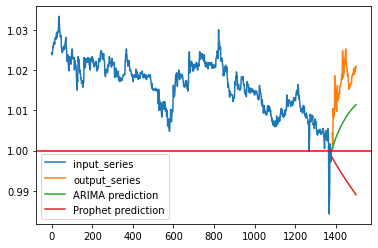

In [ ]:
idx = 1121
x_series = train_x_array[idx,:,data_col_idx]
y_series = train_y_array[idx,:,data_col_idx]

model = ARIMA(x_series, order=(3,0,1))
fit  = model.fit()
preds1 = fit.predict(1381,1380+120, typ='levels')

x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=True,
                  changepoint_prior_scale=0.06)
prophet.fit(x_df)

future_data = prophet.make_future_dataframe(periods=120, freq='min')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

pred_y = forecast_data.yhat.values[-120:]

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), preds1, label = 'ARIMA prediction')
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'Prophet prediction')
plt.legend()
plt.show()

In [ ]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 105% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    arr1 = (buy_price > 1.05) * 1
    submission.loc[:, 'buy_quantity'] = arr1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)

    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

### <4> 투자 후 금액 계산하기

In [ ]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index

# test 데이터 학습하고 추론하기

In [ ]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,data_col_idx]
        fit = None
        try:
          model = ARIMA(x_series, order=(3,0,1))
          fit  = model.fit()
        except Exception as e:
          model = ARIMA(x_series, order=(4,0,1))
          fit  = model.fit()
          
        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()
        prophet = Prophet(seasonality_mode='multiplicative', 
                          yearly_seasonality=False,
                          weekly_seasonality=False, daily_seasonality=True,
                          changepoint_prior_scale=0.06)
        prophet.fit(x_df)

        preds = fit.predict(1381,1380+120, typ='levels')

        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)
        forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        max_two_model = np.maximum(pred_y, preds)

        test_pred_array[idx,:] = max_two_model
    except Exception as e:
        print(repr(e))
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 529/529 [54:12<00:00,  6.15s/it]


## 추론한 test_pred_array를 바탕으로 submission df 생성하기

In [ ]:
submission = array_to_submission(test_x_array, test_pred_array)

In [ ]:
submission.buy_quantity.value_counts() 

0    348
1    181
Name: buy_quantity, dtype: int64

In [ ]:
submission.to_csv(data_path+"/submission.csv", index = False)